In [4]:
# ==========================================================
# UIDAI PROJECT — UNIFIED SETUP CELL (DO NOT MODIFY)
# ==========================================================

from pathlib import Path
import pandas as pd

# ---------- PATH RESOLUTION ----------
PROJECT_ROOT = Path.cwd().parent

DATA_DIR   = PROJECT_ROOT / "data"
ENROL_DIR  = DATA_DIR / "enrolment"
DEMO_DIR   = DATA_DIR / "demographic"
BIO_DIR    = DATA_DIR / "biometric"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

for p in [ENROL_DIR, DEMO_DIR, BIO_DIR]:
    if not p.exists():
        raise FileNotFoundError(f"Missing data directory: {p}")

print("📁 Project root resolved:", PROJECT_ROOT)

# ---------- DATA LOADER ----------
def load_dataset(folder: Path, pattern: str):
    files = sorted(folder.glob(pattern))
    if not files:
        raise ValueError(f"No files found in {folder} matching {pattern}")
    print(f"📄 Loading {len(files)} files from {folder.name}")
    return pd.concat(
        [pd.read_csv(f, low_memory=False) for f in files],
        ignore_index=True
    )

enrolment_full   = load_dataset(ENROL_DIR, "api_data_aadhar_enrolment_*.csv")
demographic_full = load_dataset(DEMO_DIR, "api_data_aadhar_demographic_*.csv")
biometric_full   = load_dataset(BIO_DIR, "api_data_aadhar_biometric_*.csv")

# ---------- DATE NORMALISATION ----------
for name, df in {
    "enrolment": enrolment_full,
    "demographic": demographic_full,
    "biometric": biometric_full
}.items():
    
    df.columns = [c.strip().lower() for c in df.columns]
    
    df["date"] = pd.to_datetime(
        df["date"],
        dayfirst=True,    # DD-MM-YYYY
        errors="coerce"
    )
    
    print(
        f"🕒 {name} | dtype:", df["date"].dtype,
        "| null dates:", df["date"].isna().sum()
    )

# ---------- SAFETY ASSERTIONS ----------
assert enrolment_full["date"].dtype == "datetime64[ns]"
assert demographic_full["date"].dtype == "datetime64[ns]"
assert biometric_full["date"].dtype == "datetime64[ns]"

print("✅ Unified setup completed successfully")


📁 Project root resolved: d:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress
📄 Loading 3 files from enrolment
📄 Loading 5 files from demographic
📄 Loading 4 files from biometric
🕒 enrolment | dtype: datetime64[ns] | null dates: 0
🕒 demographic | dtype: datetime64[ns] | null dates: 0
🕒 biometric | dtype: datetime64[ns] | null dates: 0
✅ Unified setup completed successfully


In [5]:
# demo_files = glob.glob("api_data_aadhar_demographic_*.csv")

# demo_dfs = []
# for f in demo_files:
#     demo_dfs.append(pd.read_csv(f))

# demographic_full = pd.concat(demo_dfs, ignore_index=True)

# print("Demographic rows:", demographic_full.shape)
# print("Date range:", demographic_full["date"].min(), demographic_full["date"].max())


In [6]:
# bio_files = glob.glob("api_data_aadhar_biometric_*.csv")

# bio_dfs = []
# for f in bio_files:
#     bio_dfs.append(pd.read_csv(f))

# biometric_full = pd.concat(bio_dfs, ignore_index=True)

# print("Biometric rows:", biometric_full.shape)
# print("Date range:", biometric_full["date"].min(), biometric_full["date"].max())


In [7]:
START_DATE = "2025-04-01"
END_DATE   = "2025-10-31"

start = pd.to_datetime(START_DATE)
end   = pd.to_datetime(END_DATE)

for df in [enrolment_full, demographic_full, biometric_full]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]

print("Rows after time filtering:")
print("Enrolment:", enrol_time.shape[0])
print("Demographic:", demo_time.shape[0])
print("Biometric:", bio_time.shape[0])


Rows after time filtering:
Enrolment: 571104
Demographic: 828847
Biometric: 836311


In [8]:
def daily_total(df):
    age_cols = [c for c in df.columns if "age" in c.lower()]
    
    daily = (
        df
        .groupby("date")[age_cols]
        .sum()
        .sum(axis=1)
        .reset_index(name="total_activity")
    )
    return daily


enrol_daily = daily_total(enrol_time)
demo_daily  = daily_total(demo_time)
bio_daily   = daily_total(bio_time)

print("Enrolment daily sample:")
print(enrol_daily.head())

print("\nDemographic daily sample:")
print(demo_daily.head())

print("\nBiometric daily sample:")
print(bio_daily.head())


Enrolment daily sample:
        date  total_activity
0 2025-04-01          257438
1 2025-05-01          183616
2 2025-06-01          215734
3 2025-07-01          616868
4 2025-09-01           74989

Demographic daily sample:
        date  total_activity
0 2025-04-01         1515672
1 2025-05-01         1566287
2 2025-06-01         1685562
3 2025-07-01         2220715
4 2025-09-01          434325

Biometric daily sample:
        date  total_activity
0 2025-04-01         8641679
1 2025-05-01         7879956
2 2025-06-01         7899289
3 2025-07-01         9792552
4 2025-09-01          336459


In [9]:
print("Enrolment days:", enrol_daily.shape[0])
print("Demographic days:", demo_daily.shape[0])
print("Biometric days:", bio_daily.shape[0])

print("\nDate ranges:")
print(enrol_daily["date"].min(), "to", enrol_daily["date"].max())
print(demo_daily["date"].min(), "to", demo_daily["date"].max())
print(bio_daily["date"].min(), "to", bio_daily["date"].max())


Enrolment days: 52
Demographic days: 42
Biometric days: 42

Date ranges:
2025-04-01 00:00:00 to 2025-10-31 00:00:00
2025-04-01 00:00:00 to 2025-10-31 00:00:00
2025-04-01 00:00:00 to 2025-10-31 00:00:00


In [10]:
all_days = pd.date_range(start="2025-04-01", end="2025-10-31")

missing_enrol = set(all_days) - set(enrol_daily["date"])
missing_demo  = set(all_days) - set(demo_daily["date"])
missing_bio   = set(all_days) - set(bio_daily["date"])

print("Missing enrolment days:", len(missing_enrol))
print("Missing demographic days:", len(missing_demo))
print("Missing biometric days:", len(missing_bio))


Missing enrolment days: 162
Missing demographic days: 172
Missing biometric days: 172


In [11]:
# rename columns to avoid confusion
enrol_daily = enrol_daily.rename(columns={"total_activity": "enrolment_total"})
demo_daily  = demo_daily.rename(columns={"total_activity": "demographic_total"})
bio_daily   = bio_daily.rename(columns={"total_activity": "biometric_total"})

# merge on date (inner join = common reporting days)
time_compare = (
    enrol_daily
    .merge(demo_daily, on="date", how="inner")
    .merge(bio_daily, on="date", how="inner")
)

print("Common reporting days:", time_compare.shape[0])
print(time_compare.head())


Common reporting days: 42
        date  enrolment_total  demographic_total  biometric_total
0 2025-04-01           257438            1515672          8641679
1 2025-05-01           183616            1566287          7879956
2 2025-06-01           215734            1685562          7899289
3 2025-07-01           616868            2220715          9792552
4 2025-09-01            74989             434325           336459


In [12]:
time_compare["demo_to_enrol_ratio"] = (
    time_compare["demographic_total"] / time_compare["enrolment_total"]
)

time_compare["bio_to_enrol_ratio"] = (
    time_compare["biometric_total"] / time_compare["enrolment_total"]
)

time_compare["bio_to_demo_ratio"] = (
    time_compare["biometric_total"] / time_compare["demographic_total"]
)

print(time_compare[[
    "date",
    "demo_to_enrol_ratio",
    "bio_to_enrol_ratio",
    "bio_to_demo_ratio"
]])


         date  demo_to_enrol_ratio  bio_to_enrol_ratio  bio_to_demo_ratio
0  2025-04-01             5.887522           33.568001           5.701550
1  2025-05-01             8.530232           42.915410           5.030978
2  2025-06-01             7.813150           36.615874           4.686442
3  2025-07-01             3.599984           15.874631           4.409639
4  2025-09-01             5.791849            4.486778           0.774671
5  2025-09-02             5.690258            4.153224           0.729883
6  2025-09-03             4.372006            4.356462           0.996445
7  2025-09-04             5.871949            4.606390           0.784474
8  2025-09-05            10.508804            3.674134           0.349624
9  2025-09-06             6.245908            4.316519           0.691095
10 2025-09-07             6.073885            2.248329           0.370163
11 2025-09-08             6.426067            4.987439           0.776126
12 2025-09-09             5.746644    

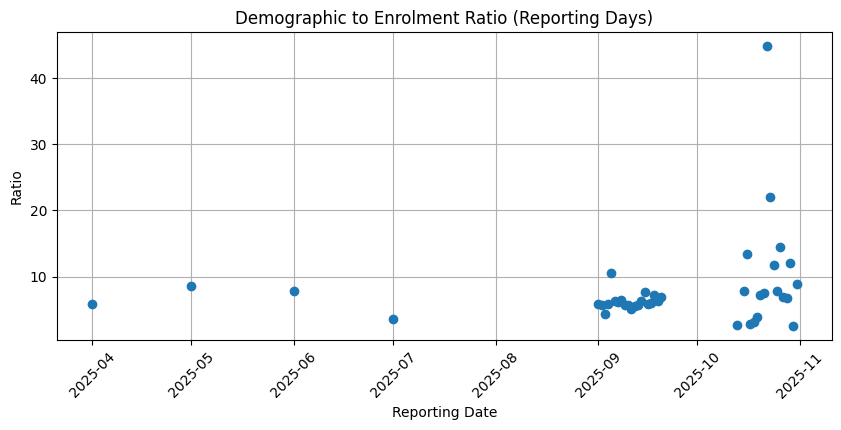

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(
    time_compare["date"],
    time_compare["demo_to_enrol_ratio"],
    marker="o",
    linestyle="None"
)
plt.title("Demographic to Enrolment Ratio (Reporting Days)")
plt.xlabel("Reporting Date")
plt.ylabel("Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


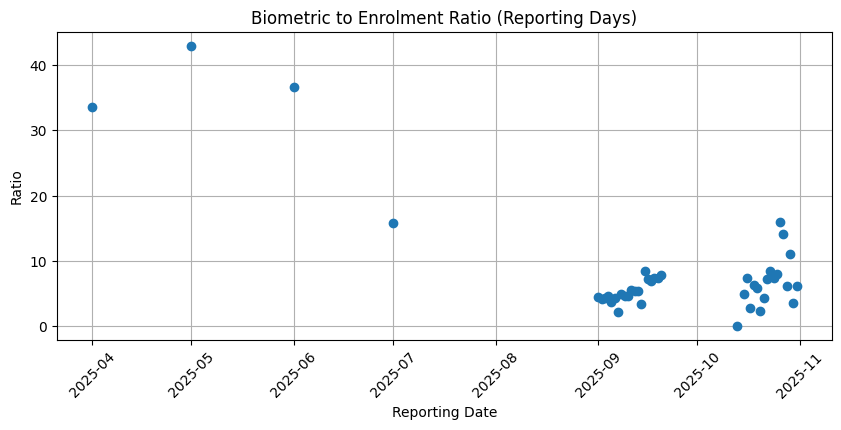

In [14]:
plt.figure(figsize=(10,4))
plt.plot(
    time_compare["date"],
    time_compare["bio_to_enrol_ratio"],
    marker="o",
    linestyle="None"
)
plt.title("Biometric to Enrolment Ratio (Reporting Days)")
plt.xlabel("Reporting Date")
plt.ylabel("Ratio")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


END OF TIMEBASED UNDERSTANDING